In [1]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 24.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


In [2]:
!pip install numpy pandas tensorflow matplotlib

In [ ]:
import cv2
import mediapipe as mp
import pandas as pd
import os
import glob
import numpy as np

# Initialize MediaPipe pose model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, model_complexity=2)

# Function to process each image and extract landmarks
def process_image(image_path, class_name, output_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    landmarks = []

    if results.pose_landmarks:
        for landmark in results.pose_landmarks.landmark:
            landmarks.extend([
                round(landmark.x, 5),
                round(landmark.y, 5),
                round(landmark.z, 5),
                round(landmark.visibility, 5)
            ])

        mp_drawing = mp.solutions.drawing_utils
        annotated_image = image.copy()
        mp_drawing.draw_landmarks(annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        annotated_path = os.path.join(output_path, class_name, os.path.basename(image_path))
        os.makedirs(os.path.dirname(annotated_path), exist_ok=True)
        cv2.imwrite(annotated_path, annotated_image)

    return landmarks

def process_directory(input_path, output_path):
    all_data = []

    for class_dir in os.listdir(input_path):
        class_path = os.path.join(input_path, class_dir)
        if os.path.isdir(class_path):
            for image_path in glob.glob(class_path + '/*/*.jpg'):
                print(f"Processing {image_path}")
                landmarks = process_image(image_path, class_dir, output_path)
                if landmarks:
                    all_data.append([class_dir] + landmarks)

    if all_data:
        # Calculate columns based on actual data
        num_features = len(all_data[0]) - 1  # Subtracting the class column
        num_landmarks = num_features // 4

        columns = ['class'] + [f'{coord}_{i}' for i in range(num_landmarks) for coord in ['x', 'y', 'z', 'visibility']]

        df = pd.DataFrame(all_data, columns=columns)

        # Ensure all numeric columns are float type
        for column in columns[1:]:  # Skip the 'class' column
            df[column] = pd.to_numeric(df[column], errors='coerce')

        csv_path = os.path.join(output_path, 'gait_data.csv')
        df.to_csv(csv_path, index=False)
        print(f"Data saved to {csv_path}")

input_path = '/content/drive/MyDrive/Dataset2/frames_00'
output_path = '/content/drive/MyDrive/Dataset2/frames_00_processed'

process_directory(input_path, output_path)


Processing /content/drive/MyDrive/Dataset2/frames_00/6/8_00/frame_0.jpg


/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Processing /content/drive/MyDrive/Dataset2/frames_00/6/8_00/frame_3.jpg
Processing /content/drive/MyDrive/Dataset2/frames_00/6/8_00/frame_2.jpg
Processing /content/drive/MyDrive/Dataset2/frames_00/6/8_00/frame_1.jpg
Processing /content/drive/MyDrive/Dataset2/frames_00/6/8_00/frame_4.jpg
Processing /content/drive/MyDrive/Dataset2/frames_00/6/8_00/frame_7.jpg
Processing /content/drive/MyDrive/Dataset2/frames_00/6/8_00/frame_6.jpg
Processing /content/drive/MyDrive/Dataset2/frames_00/6/8_00/frame_5.jpg
Processing /content/drive/MyDrive/Dataset2/frames_00/6/8_00/frame_9.jpg
Processing /content/drive/MyDrive/Dataset2/frames_00/6/8_00/frame_11.jpg
Processing /content/drive/MyDrive/Dataset2/frames_00/6/8_00/frame_10.jpg
Processing /content/drive/MyDrive/Dataset2/frames_00/6/8_00/frame_8.jpg
Processing /content/drive/MyDrive/Dataset2/frames_00/6/8_00/frame_14.jpg
Processing /content/drive/MyDrive/Dataset2/frames_00/6/8_00/frame_15.jpg
Processing /content/drive/MyDrive/Dataset2/frames_00/6/8_00/

In [ ]:
import pandas as pd

# Function to sort CSV data and move 'class' column to the end
def sort_csv(input_csv_path, output_csv_path, sort_column):
    # Read the CSV file
    df = pd.read_csv(input_csv_path)

    # Sort the DataFrame by the specified column
    sorted_df = df.sort_values(by=sort_column, ascending=True)

    # Move the 'class' column to the end
    if 'class' in sorted_df.columns:
        class_column = sorted_df.pop('class')
        sorted_df['class'] = class_column

    # Write the sorted DataFrame back to a new CSV file
    sorted_df.to_csv(output_csv_path, index=False)
    print(f"Data sorted by {sort_column} and saved to {output_csv_path}")

# Example usage
input_csv_path = '/content/drive/MyDrive/Dataset2/frames_00_processed/gait_data.csv'  # Path to your input CSV file
output_csv_path = '/content/drive/MyDrive/Dataset2/frames_00_processed/gait_data_sorted.csv'  # Path to save the sorted CSV file
sort_column = 'class'  # Replace with the column name you want to sort by

sort_csv(input_csv_path, output_csv_path, sort_column)


Data sorted by class and saved to /content/drive/MyDrive/Dataset2/frames_00_processed/gait_data_sorted.csv


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your dataset with the specified encoding
data = pd.read_csv('/content/drive/MyDrive/Dataset2/frames_00_processed/gait_data_sorted.csv')

# Assuming the last column is the target
feature_columns = data.columns[:-1]  # All columns except the last one
target_column = data.columns[-1]     # Last column as target

# Prepare features (X) and targets (y)
X = data[feature_columns]
y = data[target_column]

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Optionally, verify the stratification and the split
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# Save the splits to new CSV files for future use
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.to_csv('/content/drive/MyDrive/Dataset2/train_test/gait_data.train.csv', index=False)
test_data.to_csv('/content/drive/MyDrive/Dataset2/train_test/gait_data.test.csv', index=False)

print("Data has been split and saved into training and testing CSV files.")


Training set size: 1070 samples
Testing set size: 268 samples
Data has been split and saved into training and testing CSV files.


Training Metrics (Accuracy, Recall, Precision, F1): {'Accuracy': 1.0, 'Recall': 1.0, 'Precision': 1.0, 'F1 Score': 1.0}
Testing Metrics (Accuracy, Recall, Precision, F1): {'Accuracy': 0.8619402985074627, 'Recall': 0.8619402985074627, 'Precision': 0.866861702909374, 'F1 Score': 0.862488379480401}
Metrics plot saved to /content/drive/MyDrive/Dataset2/models/decision_tree_metrics.png
Confusion matrices plot saved to /content/drive/MyDrive/Dataset2/models/decision_tree_confusion_matrices.png


<Figure size 1000x600 with 0 Axes>

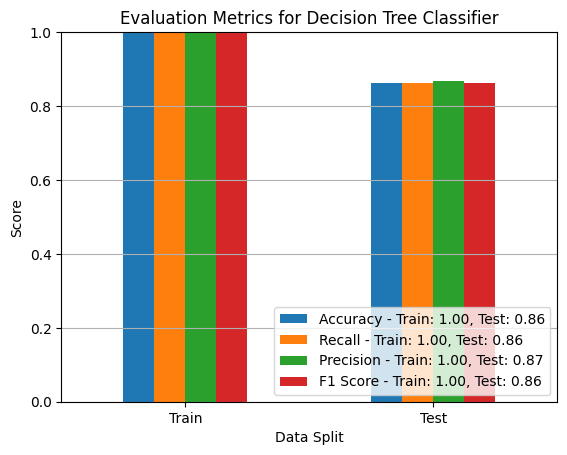

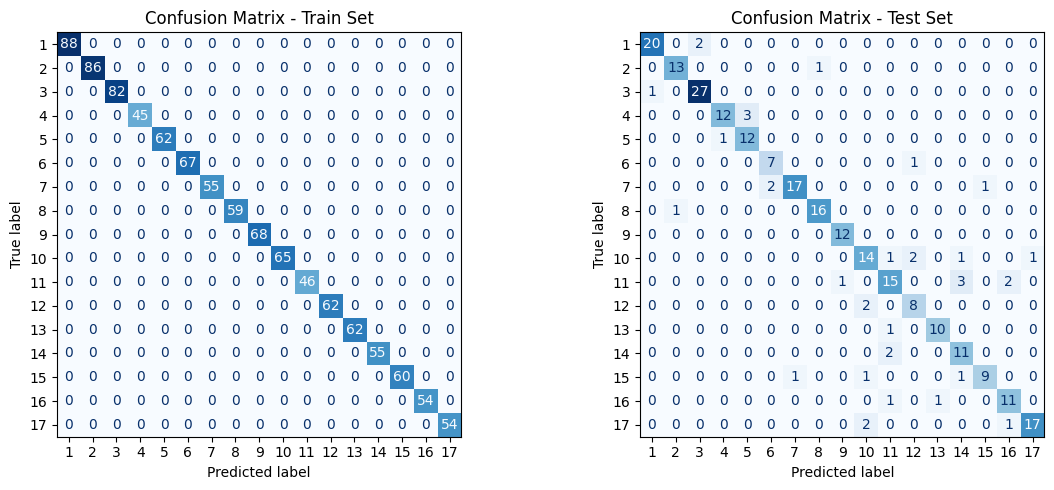

In [ ]:
############### Decision Tree ######################

# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree Classifier
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

# Save the model
joblib.dump(classifier, '/content/drive/MyDrive/Dataset2/models/decision_tree_model.pkl')

# Make predictions
y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

# Calculate evaluation metrics
metrics_train = {
    "Accuracy": accuracy_score(y_train, y_train_pred),
    "Recall": recall_score(y_train, y_train_pred, average='weighted'),
    "Precision": precision_score(y_train, y_train_pred, average='weighted'),
    "F1 Score": f1_score(y_train, y_train_pred, average='weighted')
}
metrics_test = {
    "Accuracy": accuracy_score(y_test, y_test_pred),
    "Recall": recall_score(y_test, y_test_pred, average='weighted'),
    "Precision": precision_score(y_test, y_test_pred, average='weighted'),
    "F1 Score": f1_score(y_test, y_test_pred, average='weighted')
}

# Print the metrics
print("Training Metrics (Accuracy, Recall, Precision, F1):", metrics_train)
print("Testing Metrics (Accuracy, Recall, Precision, F1):", metrics_test)

# Plot the metrics
metrics_df = pd.DataFrame([metrics_train, metrics_test], index=['Train', 'Test'])

plt.figure(figsize=(10, 6))
ax = metrics_df.plot(kind='bar')
plt.title('Evaluation Metrics for Decision Tree Classifier')
plt.xlabel('Data Split')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y')

# Update legend with exact metric values
handles, labels = ax.get_legend_handles_labels()
new_labels = [f'{label} - Train: {metrics_train[label]:.2f}, Test: {metrics_test[label]:.2f}' for label in labels]
ax.legend(handles, new_labels, loc='lower right')

# Save the metrics plot
metrics_plot_path = '/content/drive/MyDrive/Dataset2/models/decision_tree_metrics.png'
plt.savefig(metrics_plot_path)
print(f"Metrics plot saved to {metrics_plot_path}")

# Plot confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=ax[0], cmap='Blues', colorbar=False)
ax[0].set_title('Confusion Matrix - Train Set')

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=ax[1], cmap='Blues', colorbar=False)
ax[1].set_title('Confusion Matrix - Test Set')

plt.tight_layout()

# Save the confusion matrices plot
conf_matrix_plot_path = '/content/drive/MyDrive/Dataset2/models/decision_tree_confusion_matrices.png'
plt.savefig(conf_matrix_plot_path)
print(f"Confusion matrices plot saved to {conf_matrix_plot_path}")

plt.show()


Training Metrics (Accuracy, Recall, Precision, F1): {'Accuracy': 1.0, 'Recall': 1.0, 'Precision': 1.0, 'F1 Score': 1.0}
Testing Metrics (Accuracy, Recall, Precision, F1): {'Accuracy': 0.9813432835820896, 'Recall': 0.9813432835820896, 'Precision': 0.9837107565620175, 'F1 Score': 0.981546789553147}
Metrics plot saved to /content/drive/MyDrive/Dataset2/models/random_forest_metrics.png
Confusion matrices plot saved to /content/drive/MyDrive/Dataset2/models/random_forest_confusion_matrices.png


<Figure size 1000x600 with 0 Axes>

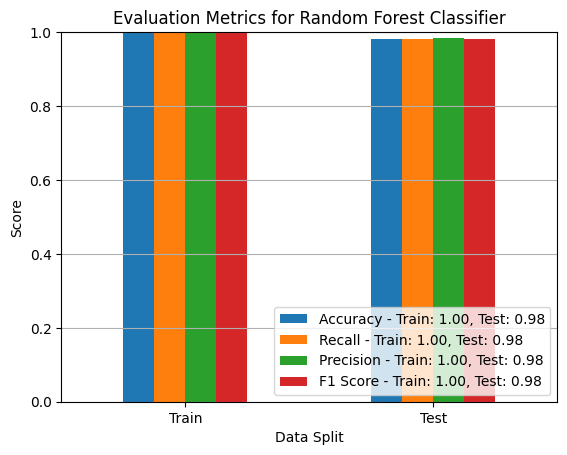

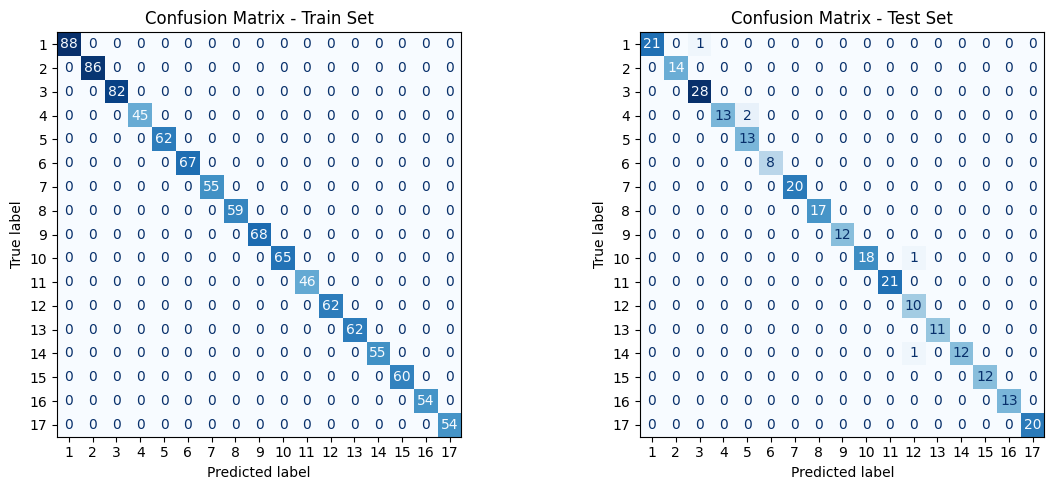

In [ ]:
############### Random Forest ######################

# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

# Save the model
joblib.dump(classifier, '/content/drive/MyDrive/Dataset2/models/random_forest_model.pkl')

# Make predictions
y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

# Calculate evaluation metrics
metrics_train = {
    "Accuracy": accuracy_score(y_train, y_train_pred),
    "Recall": recall_score(y_train, y_train_pred, average='weighted'),
    "Precision": precision_score(y_train, y_train_pred, average='weighted'),
    "F1 Score": f1_score(y_train, y_train_pred, average='weighted')
}
metrics_test = {
    "Accuracy": accuracy_score(y_test, y_test_pred),
    "Recall": recall_score(y_test, y_test_pred, average='weighted'),
    "Precision": precision_score(y_test, y_test_pred, average='weighted'),
    "F1 Score": f1_score(y_test, y_test_pred, average='weighted')
}

# Print the metrics
print("Training Metrics (Accuracy, Recall, Precision, F1):", metrics_train)
print("Testing Metrics (Accuracy, Recall, Precision, F1):", metrics_test)

# Plot the metrics
metrics_df = pd.DataFrame([metrics_train, metrics_test], index=['Train', 'Test'])

plt.figure(figsize=(10, 6))
ax = metrics_df.plot(kind='bar')
plt.title('Evaluation Metrics for Random Forest Classifier')
plt.xlabel('Data Split')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')



# Update legend with exact metric values
handles, labels = ax.get_legend_handles_labels()
new_labels = [f'{label} - Train: {metrics_train[label]:.2f}, Test: {metrics_test[label]:.2f}' for label in labels]
ax.legend(handles, new_labels, loc='lower right')


# Save the metrics plot
metrics_plot_path = '/content/drive/MyDrive/Dataset2/models/random_forest_metrics.png'
plt.savefig(metrics_plot_path)
print(f"Metrics plot saved to {metrics_plot_path}")

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title('Confusion Matrix - Train Set')

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title('Confusion Matrix - Test Set')

plt.tight_layout()

# Save the confusion matrices plot
conf_matrix_plot_path = '/content/drive/MyDrive/Dataset2/models/random_forest_confusion_matrices.png'
plt.savefig(conf_matrix_plot_path)
print(f"Confusion matrices plot saved to {conf_matrix_plot_path}")

plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Metrics (Accuracy, Recall, Precision, F1): {'Accuracy': 0.4691588785046729, 'Recall': 0.4691588785046729, 'Precision': 0.49236141834794356, 'F1 Score': 0.4274484865550164}
Testing Metrics (Accuracy, Recall, Precision, F1): {'Accuracy': 0.41044776119402987, 'Recall': 0.41044776119402987, 'Precision': 0.5275728987561275, 'F1 Score': 0.3750189074643197}
Metrics plot saved to /content/drive/MyDrive/Dataset2/models/svm_metrics.png
Confusion matrices plot saved to /content/drive/MyDrive/Dataset2/models/svm_confusion_matrices.png


<Figure size 1000x600 with 0 Axes>

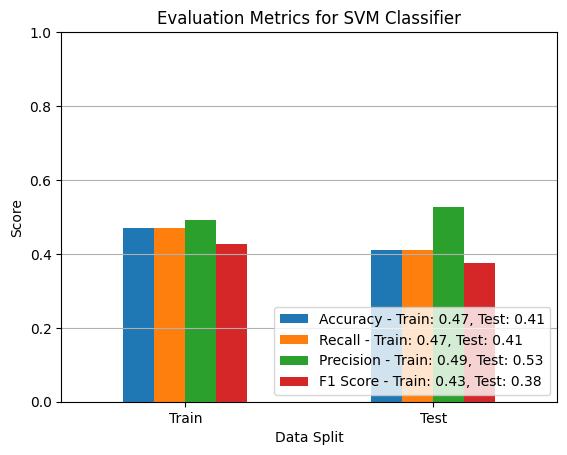

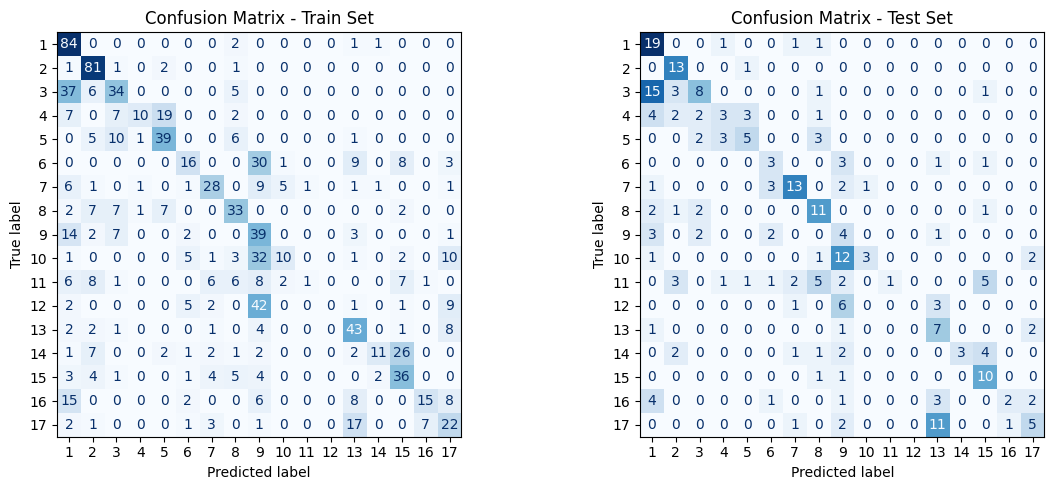

In [ ]:
############### Support Vector Machine (SVM) ######################

# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree Classifier
classifier = SVC()
classifier.fit(X_train, y_train)

# Save the model
joblib.dump(classifier, '/content/drive/MyDrive/Dataset2/models/svm_model.pkl')

# Make predictions
y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

# Calculate evaluation metrics
metrics_train = {
    "Accuracy": accuracy_score(y_train, y_train_pred),
    "Recall": recall_score(y_train, y_train_pred, average='weighted'),
    "Precision": precision_score(y_train, y_train_pred, average='weighted'),
    "F1 Score": f1_score(y_train, y_train_pred, average='weighted')
}
metrics_test = {
    "Accuracy": accuracy_score(y_test, y_test_pred),
    "Recall": recall_score(y_test, y_test_pred, average='weighted'),
    "Precision": precision_score(y_test, y_test_pred, average='weighted'),
    "F1 Score": f1_score(y_test, y_test_pred, average='weighted')
}

# Print the metrics
print("Training Metrics (Accuracy, Recall, Precision, F1):", metrics_train)
print("Testing Metrics (Accuracy, Recall, Precision, F1):", metrics_test)

# Plot the metrics
metrics_df = pd.DataFrame([metrics_train, metrics_test], index=['Train', 'Test'])

plt.figure(figsize=(10, 6))
ax = metrics_df.plot(kind='bar')
plt.title('Evaluation Metrics for SVM Classifier')
plt.xlabel('Data Split')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y')

# Update legend with exact metric values
handles, labels = ax.get_legend_handles_labels()
new_labels = [f'{label} - Train: {metrics_train[label]:.2f}, Test: {metrics_test[label]:.2f}' for label in labels]
ax.legend(handles, new_labels, loc='lower right')

# Save the metrics plot
metrics_plot_path = '/content/drive/MyDrive/Dataset2/models/svm_metrics.png'
plt.savefig(metrics_plot_path)
print(f"Metrics plot saved to {metrics_plot_path}")

# Plot confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=ax[0], cmap='Blues', colorbar=False)
ax[0].set_title('Confusion Matrix - Train Set')

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=ax[1], cmap='Blues', colorbar=False)
ax[1].set_title('Confusion Matrix - Test Set')

plt.tight_layout()

# Save the confusion matrices plot
conf_matrix_plot_path = '/content/drive/MyDrive/Dataset2/models/svm_confusion_matrices.png'
plt.savefig(conf_matrix_plot_path)
print(f"Confusion matrices plot saved to {conf_matrix_plot_path}")

plt.show()


Training Metrics (Accuracy, Recall, Precision, F1): {'Accuracy': 0.8065420560747664, 'Recall': 0.8065420560747664, 'Precision': 0.8115413871166199, 'F1 Score': 0.8018887674834636}
Testing Metrics (Accuracy, Recall, Precision, F1): {'Accuracy': 0.6604477611940298, 'Recall': 0.6604477611940298, 'Precision': 0.7045845280311536, 'F1 Score': 0.6544195480782625}
Metrics plot saved to /content/drive/MyDrive/Dataset2/models/knn_metrics.png
Confusion matrices plot saved to /content/drive/MyDrive/Dataset2/models/knn_confusion_matrices.png


<Figure size 1000x600 with 0 Axes>

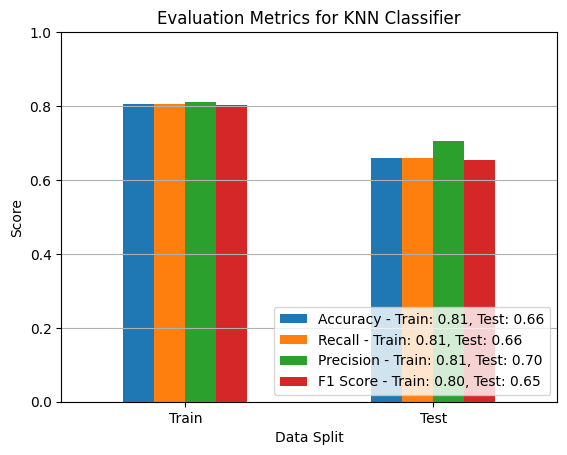

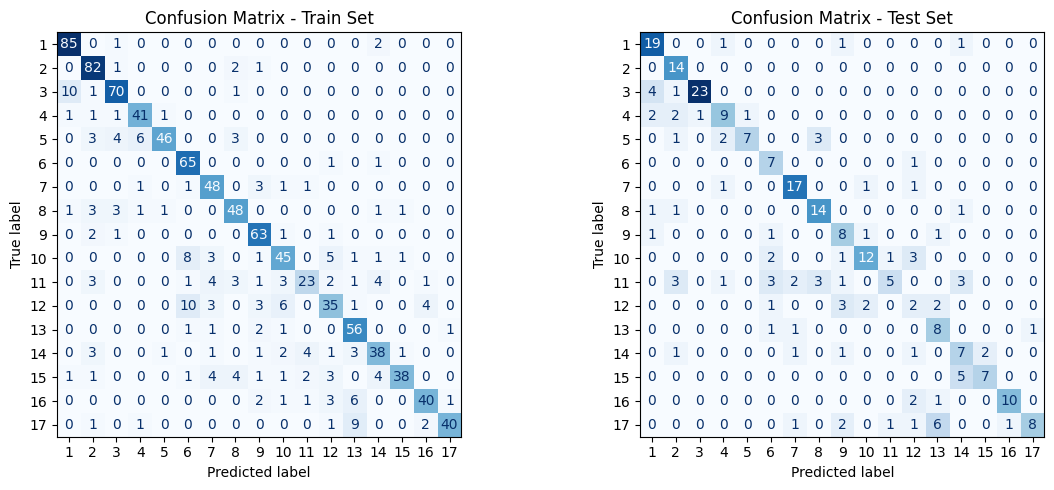

In [5]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier  # Import KNN classifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the KNN Classifier
classifier = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors here
classifier.fit(X_train, y_train)

# Save the model
joblib.dump(classifier, '/content/drive/MyDrive/Dataset2/models/knn_model.pkl')

# Make predictions
y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

# Calculate evaluation metrics
metrics_train = {
    "Accuracy": accuracy_score(y_train, y_train_pred),
    "Recall": recall_score(y_train, y_train_pred, average='weighted'),
    "Precision": precision_score(y_train, y_train_pred, average='weighted'),
    "F1 Score": f1_score(y_train, y_train_pred, average='weighted')
}
metrics_test = {
    "Accuracy": accuracy_score(y_test, y_test_pred),
    "Recall": recall_score(y_test, y_test_pred, average='weighted'),
    "Precision": precision_score(y_test, y_test_pred, average='weighted'),
    "F1 Score": f1_score(y_test, y_test_pred, average='weighted')
}

# Print the metrics
print("Training Metrics (Accuracy, Recall, Precision, F1):", metrics_train)
print("Testing Metrics (Accuracy, Recall, Precision, F1):", metrics_test)

# Plot the metrics
metrics_df = pd.DataFrame([metrics_train, metrics_test], index=['Train', 'Test'])

plt.figure(figsize=(10, 6))
ax = metrics_df.plot(kind='bar')
plt.title('Evaluation Metrics for KNN Classifier')
plt.xlabel('Data Split')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y')

# Update legend with exact metric values
handles, labels = ax.get_legend_handles_labels()
new_labels = [f'{label} - Train: {metrics_train[label]:.2f}, Test: {metrics_test[label]:.2f}' for label in labels]
ax.legend(handles, new_labels, loc='lower right')

# Save the metrics plot
metrics_plot_path = '/content/drive/MyDrive/Dataset2/models/knn_metrics.png'
plt.savefig(metrics_plot_path)
print(f"Metrics plot saved to {metrics_plot_path}")

# Plot confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=ax[0], cmap='Blues', colorbar=False)
ax[0].set_title('Confusion Matrix - Train Set')

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=ax[1], cmap='Blues', colorbar=False)
ax[1].set_title('Confusion Matrix - Test Set')

plt.tight_layout()

# Save the confusion matrices plot
conf_matrix_plot_path = '/content/drive/MyDrive/Dataset2/models/knn_confusion_matrices.png'
plt.savefig(conf_matrix_plot_path)
print(f"Confusion matrices plot saved to {conf_matrix_plot_path}")

plt.show()
